# Twitter Topic Modeling



Task: Utlizing a common dataset called CIFAR-10 that has 60,000 images separated into 10 classes for image classification. Classes: 
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


In [ ]:
import math

import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data

sns.set()
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INPUT_SIZE = 3 * 32 * 32  # Image dimensions: 32x32 pixels, 3 channels (RGB)
NUM_CLASSES = 10  # Number of output classes (0-9)
BATCH_SIZE = 64  # Size of each training batch
DEBUG_MODE = False  # Set to True for faster training during development.

In [ ]:
INPUT_SIZE    = 3 * 32 * 32  
NUM_CLASSES   = 10            
BATCH_SIZE    = 100            
SAMPLE_DATA   = False       

Apply data transformations, including normalization, and load the CIFAR-10 dataset.
If SAMPLE_DATA is True, use a smaller subset for faster training during development.

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

if SAMPLE_DATA:  
    trainset, _ = torch.utils.data.random_split(trainset, [BATCH_SIZE * 10, len(trainset) - BATCH_SIZE * 10])
    valset, _ = torch.utils.data.random_split(valset, [BATCH_SIZE * 10, len(valset) - BATCH_SIZE * 10])


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 43328319.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainset

----
In the cell below, we define the critical helper functions to train and visualize the results of the neural networks. You should read and understand what they are doing.

In [ ]:
def train(net, train_loader, val_loader,
          num_epochs, learning_rate,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and val accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, val_loader: The pytorch dataset loaders for the trainset and valset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and val
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and val accuracies if compute_accs is True, None otherwise
    """
    # Initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    val_accs = []
    best_val_acc = 0

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   

            images = images.to(device)
            labels = labels.to(device)


            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if batch_num % 100 == 0:  # Print every 100 batches
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            batch_num += 1

        if compute_accs:
            train_acc = accuracy(net, train_loader)
            val_acc = accuracy(net, val_loader)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            best_val_acc = max(best_val_acc, val_acc)
            print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Validation Accuracy {100 * val_acc:.2f}%')
            print(f'Best Validation Accuracy {100 * best_val_acc:.2f}%')

    if compute_accs:
        return train_accs, val_accs, best_val_acc


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/validation accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies
                        * val_accs: A list of val accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['val_accs'],
                     '--', label=model_history['name'] + ' Validation')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=model_history['name'] + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

Implemented a neural network (`NetA`) with one hidden layer. The network flattens the input image, 
applies a fully connected layer with 300 neurons followed by a ReLU activation, 
and then uses another fully connected layer to produce 10 output classes.

In [ ]:
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 300)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(300,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Developed a deeper neural network with two hidden layers. 
The network flattens the input image, applies a fully connected 
layer with 100 neurons followed by a ReLU activation, then another
 fully connected layer with 60 neurons and a ReLU activation, 
and finally outputs 10 classes through a fully connected layer.

In [ ]:
class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100,60)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

Implemented a convolutional neural network (CNN) with the following architecture: 
a convolutional layer with a kernel size of 5 and depth of 25, 
followed by ReLU activation and max-pooling with a kernel 
size of 2 and stride of 2. The output is then flattened and
 passed through a fully connected layer to produce 10 output classes.

In [ ]:
class NetC(nn.Module):
    def __init__(self,):
        super(NetC, self).__init__()
        self.conv = nn.Conv2d(3, 25, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4900, 10)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 4900)
        x = self.fc1(x)
        return x

Designed a custom neural network (`NetD`) with at least 2 
convolutional layers, each followed by a pooling operation, 
and at least 2 fully connected layers. Every convolution and 
linear layer includes an activation function, except for the 
final output layer. The goal is to achieve at least 65% validation 
accuracy with this architecture.

In [ ]:
class NetD(nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4096, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 4096)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

Model Validation Percentages

### 1. `NetA`

==== Training NetA ====


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Train Accuracy 44.60%, Validation Accuracy 33.10%
Best Validation Accuracy 33.10%
Epoch [2/10], Train Accuracy 55.20%, Validation Accuracy 34.00%
Best Validation Accuracy 34.00%
Epoch [3/10], Train Accuracy 65.30%, Validation Accuracy 36.50%
Best Validation Accuracy 36.50%
Epoch [4/10], Train Accuracy 72.10%, Validation Accuracy 36.00%
Best Validation Accuracy 36.50%
Epoch [5/10], Train Accuracy 79.20%, Validation Accuracy 36.60%
Best Validation Accuracy 36.60%
Epoch [6/10], Train Accuracy 85.80%, Validation Accuracy 37.50%
Best Validation Accuracy 37.50%
Epoch [7/10], Train Accuracy 91.30%, Validation Accuracy 37.00%
Best Validation Accuracy 37.50%
Epoch [8/10], Train Accuracy 92.70%, Validation Accuracy 38.40%
Best Validation Accuracy 38.40%
Epoch [9/10], Train Accuracy 95.30%, Validation Accuracy 37.30%
Best Validation Accuracy 38.40%
Epoch [10/10], Train Accuracy 96.10%, Validation Accuracy 35.20%
Best Validation Accuracy 38.40%


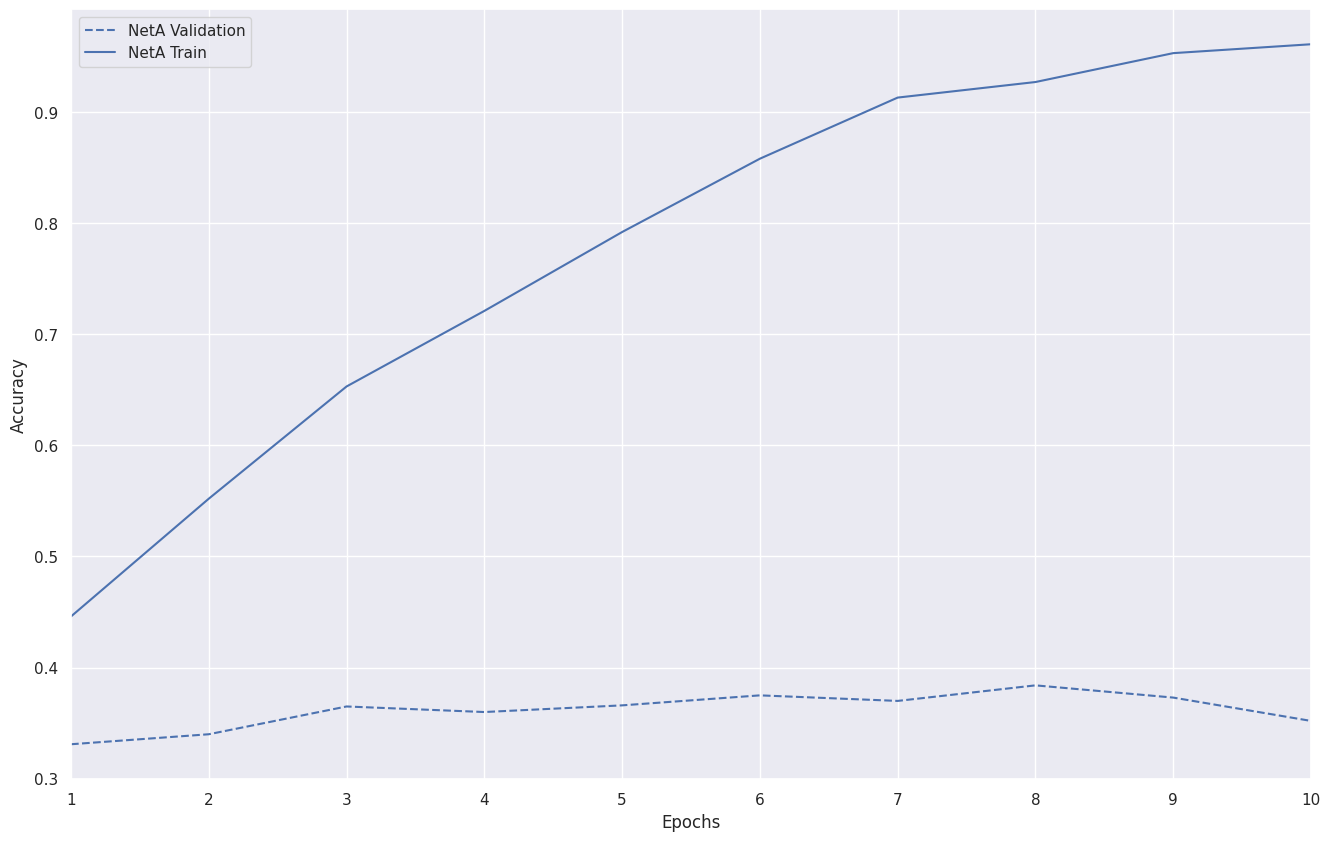

In [ ]:
histories_A = []

netA = NetA()
print(f'==== Training NetA ====')
netA.to(device)
train_history_A, val_history_A, _ = train(netA, train_loader, val_loader,
    num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_A.append({
      'name': 'NetA',
      'train_accs': train_history_A,
      'val_accs': val_history_A
})
plot_history(histories_A)

### 2. `NetB`

==== Training NetB ====
Epoch [1/10], Train Accuracy 32.40%, Validation Accuracy 26.60%
Best Validation Accuracy 26.60%
Epoch [2/10], Train Accuracy 39.00%, Validation Accuracy 31.90%
Best Validation Accuracy 31.90%
Epoch [3/10], Train Accuracy 47.50%, Validation Accuracy 34.60%
Best Validation Accuracy 34.60%
Epoch [4/10], Train Accuracy 53.20%, Validation Accuracy 34.50%
Best Validation Accuracy 34.60%
Epoch [5/10], Train Accuracy 58.40%, Validation Accuracy 35.90%
Best Validation Accuracy 35.90%
Epoch [6/10], Train Accuracy 61.90%, Validation Accuracy 35.00%
Best Validation Accuracy 35.90%
Epoch [7/10], Train Accuracy 68.90%, Validation Accuracy 35.10%
Best Validation Accuracy 35.90%
Epoch [8/10], Train Accuracy 72.30%, Validation Accuracy 36.00%
Best Validation Accuracy 36.00%
Epoch [9/10], Train Accuracy 77.70%, Validation Accuracy 35.40%
Best Validation Accuracy 36.00%
Epoch [10/10], Train Accuracy 77.80%, Validation Accuracy 35.00%
Best Validation Accuracy 36.00%


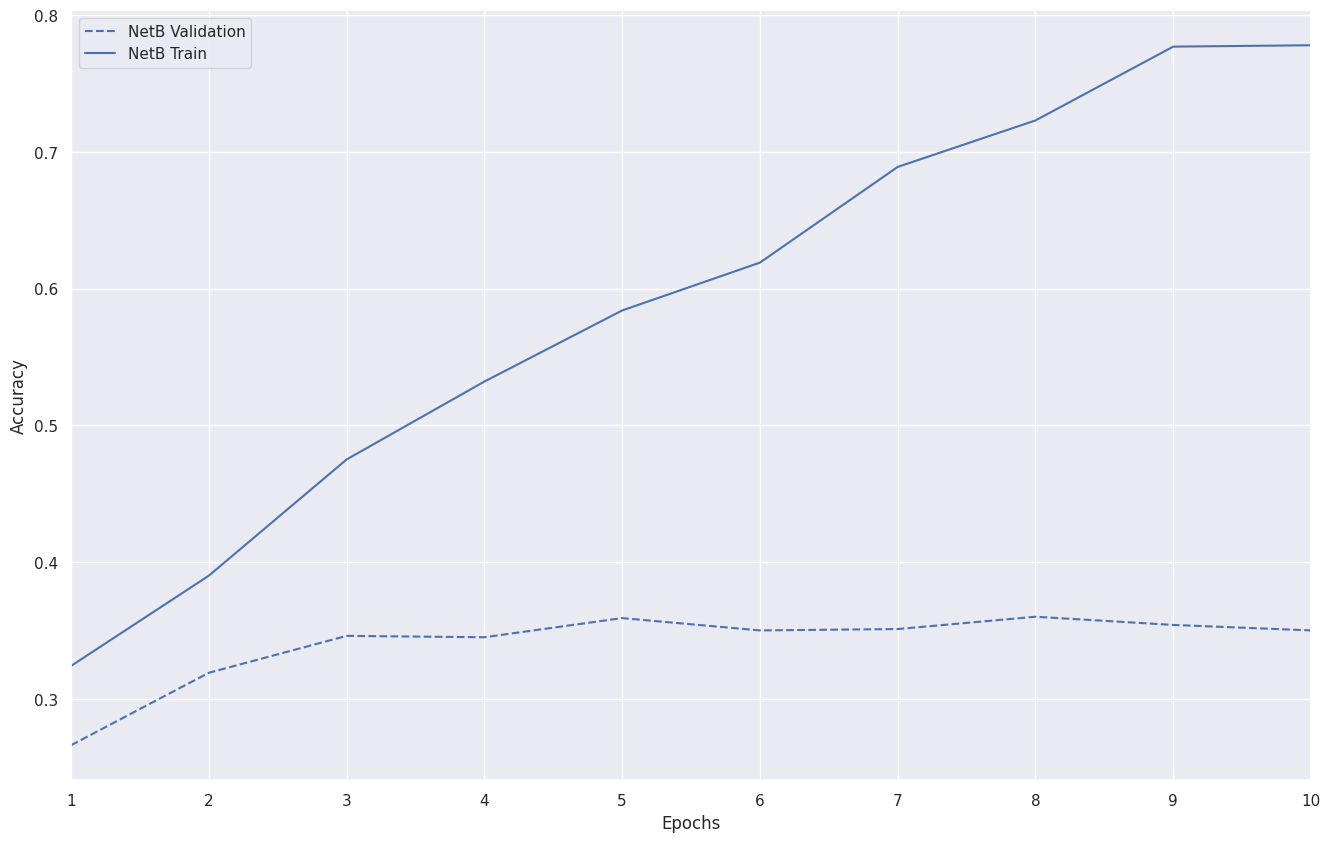

In [ ]:
histories_B = []

netB = NetB()
print(f'==== Training NetB ====')
netB.to(device)
train_history_B, val_history_B, _ = train(netB, train_loader, val_loader,
        num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_B.append({
      'name': 'NetB',
      'train_accs': train_history_B,
      'val_accs': val_history_B
})
plot_history(histories_B)

### 3. `NetC`

==== Training NetC ====
Epoch [1/10], Train Accuracy 32.80%, Validation Accuracy 27.50%
Best Validation Accuracy 27.50%
Epoch [2/10], Train Accuracy 44.50%, Validation Accuracy 34.40%
Best Validation Accuracy 34.40%
Epoch [3/10], Train Accuracy 46.70%, Validation Accuracy 34.00%
Best Validation Accuracy 34.40%
Epoch [4/10], Train Accuracy 52.80%, Validation Accuracy 37.70%
Best Validation Accuracy 37.70%
Epoch [5/10], Train Accuracy 57.40%, Validation Accuracy 36.90%
Best Validation Accuracy 37.70%
Epoch [6/10], Train Accuracy 61.00%, Validation Accuracy 40.70%
Best Validation Accuracy 40.70%
Epoch [7/10], Train Accuracy 64.00%, Validation Accuracy 39.00%
Best Validation Accuracy 40.70%
Epoch [8/10], Train Accuracy 70.10%, Validation Accuracy 40.10%
Best Validation Accuracy 40.70%
Epoch [9/10], Train Accuracy 75.30%, Validation Accuracy 40.80%
Best Validation Accuracy 40.80%
Epoch [10/10], Train Accuracy 79.10%, Validation Accuracy 42.90%
Best Validation Accuracy 42.90%


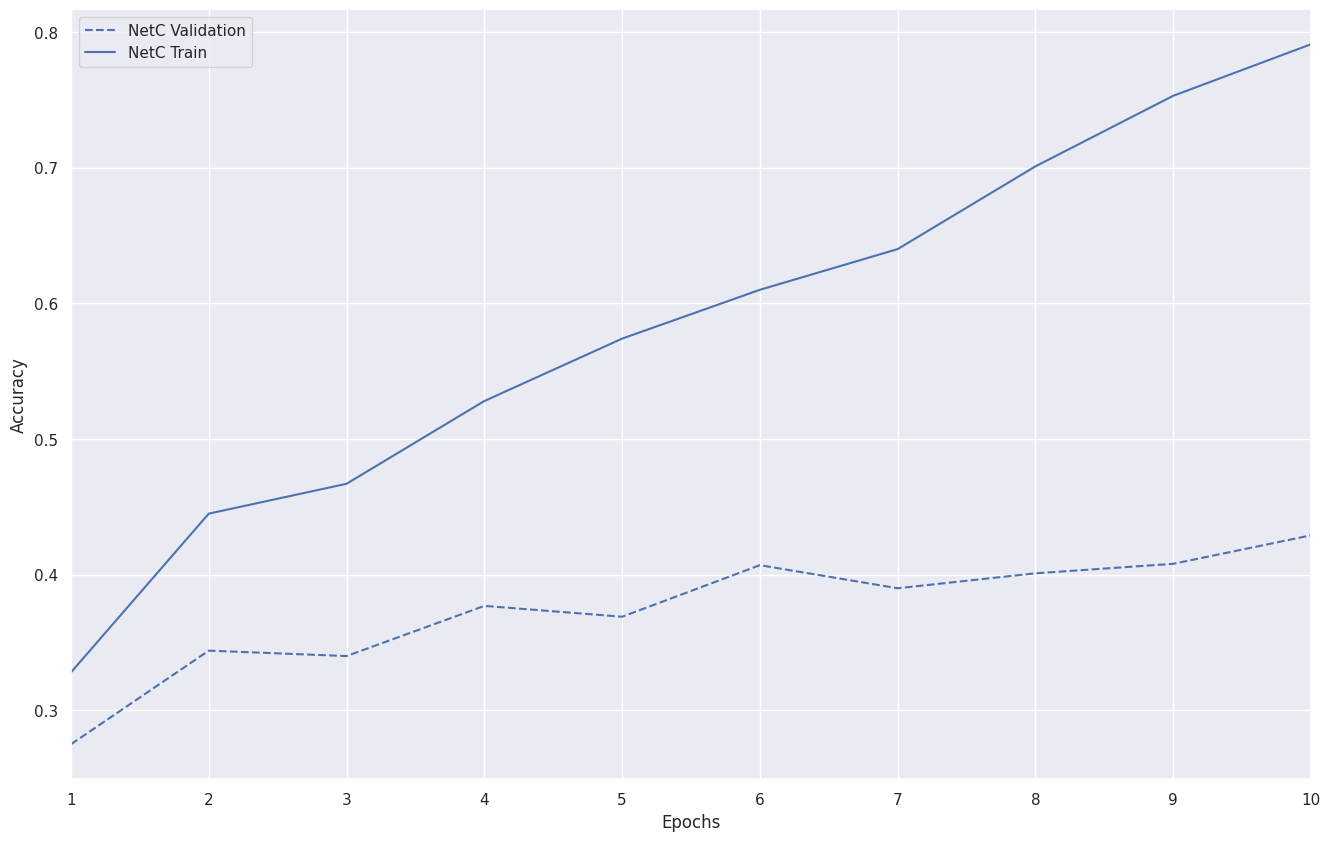

In [ ]:
histories_C = []

netC = NetC()
print(f'==== Training NetC ====')
netC.to(device)
train_history_C, val_history_C, _ = train(netC, train_loader, val_loader,
        num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_C.append({
      'name': 'NetC',
      'train_accs': train_history_C,
      'val_accs': val_history_C
})
plot_history(histories_C)

### 4. `NetD`

==== Training NetD ====
Epoch [1/10], Train Accuracy 25.50%, Validation Accuracy 20.40%
Best Validation Accuracy 20.40%
Epoch [2/10], Train Accuracy 30.30%, Validation Accuracy 30.90%
Best Validation Accuracy 30.90%
Epoch [3/10], Train Accuracy 35.60%, Validation Accuracy 35.60%
Best Validation Accuracy 35.60%
Epoch [4/10], Train Accuracy 38.90%, Validation Accuracy 37.10%
Best Validation Accuracy 37.10%
Epoch [5/10], Train Accuracy 41.80%, Validation Accuracy 37.90%
Best Validation Accuracy 37.90%
Epoch [6/10], Train Accuracy 44.80%, Validation Accuracy 37.10%
Best Validation Accuracy 37.90%
Epoch [7/10], Train Accuracy 48.50%, Validation Accuracy 40.40%
Best Validation Accuracy 40.40%
Epoch [8/10], Train Accuracy 51.90%, Validation Accuracy 41.90%
Best Validation Accuracy 41.90%
Epoch [9/10], Train Accuracy 56.20%, Validation Accuracy 42.00%
Best Validation Accuracy 42.00%
Epoch [10/10], Train Accuracy 51.70%, Validation Accuracy 38.70%
Best Validation Accuracy 42.00%


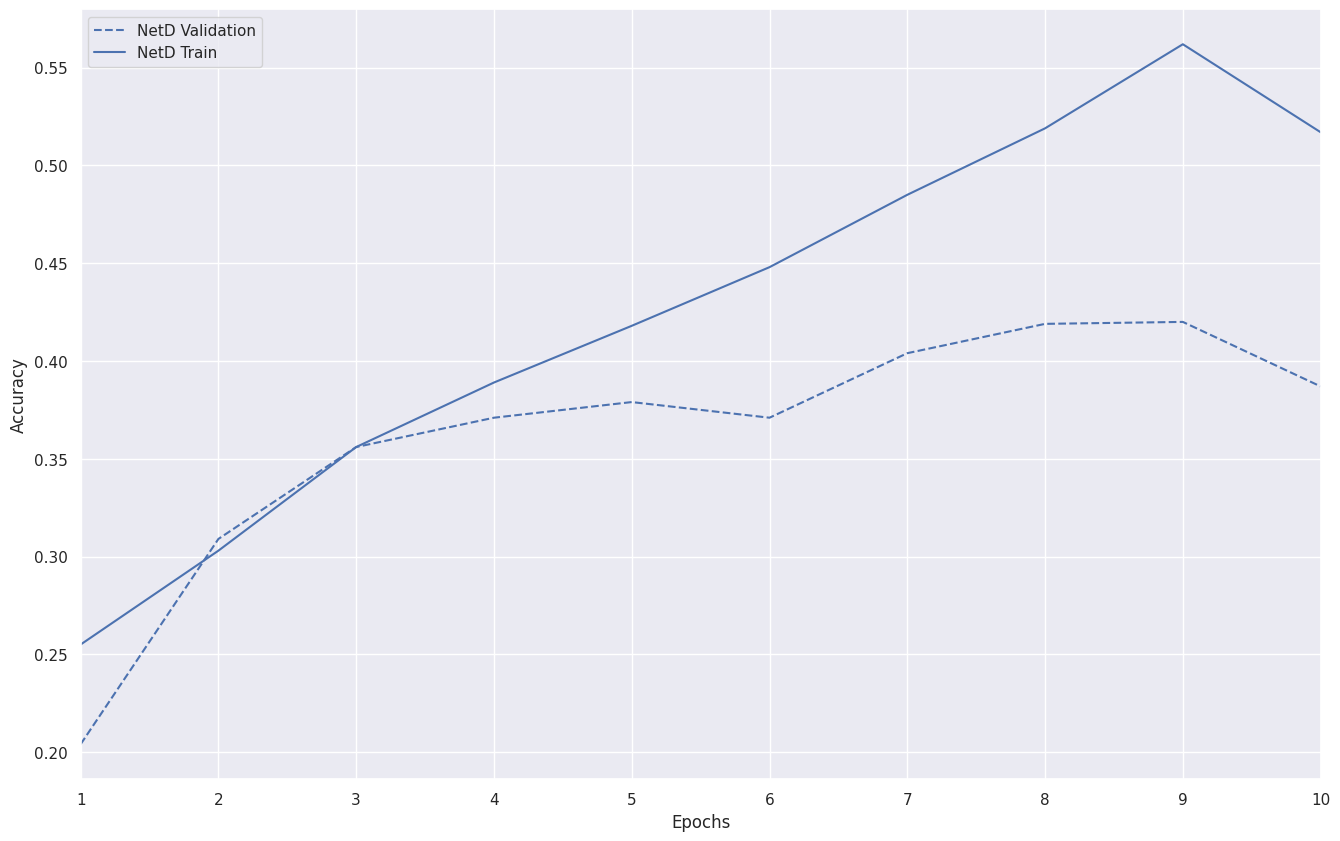

In [ ]:
histories_D = []

netD = NetD()
print(f'==== Training NetD ====')
netD.to(device)
train_history_D, val_history_D, _ = train(netD, train_loader, val_loader,
        num_epochs=10, learning_rate=1e-3, compute_accs=True)
histories_D.append({
      'name': 'NetD',
      'train_accs': train_history_D,
      'val_accs': val_history_D
})
plot_history(histories_D)